# Insoluble monolayers

Experiments can be carried out on insoluble monolayers of material. This notebook explains how one would create and fit a model to data from such experiments. The dataset used is from Woden et al. (2021) (https://doi.org/10.5194/acp-21-1325-2021).

This dataset is from a monolayer of deuterated oleic acid on an aqueous subphase. We will assume that none of the products evaporate from the surface and keep them lumped together as a "products" component for simplicity. 

The reaction scheme is consistent with other MultilayerPy tutorials: `oleic acid + ozone --> products`

In [1]:
# importing the necessaries
import numpy as np
import multilayerpy
import multilayerpy.build as build 
import multilayerpy.simulate as simulate
import multilayerpy.optimize as optimize
import scipy

# check the version
print(multilayerpy.__version__)

    
    MultilayerPy - build, run and optimise kinetic multi-layer models for 
    aerosol particles and films.
    
    Copyright (C) 2022 Adam Milsom

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.
    
    Version: 0.0.2dev
    
    

0.0.2dev


In [2]:
# import the ModelType class
from multilayerpy.build import ModelType

# import the ReactionScheme class
from multilayerpy.build import ReactionScheme

# define the model type (KM-SUB in this case) and geometry (film)
mod_type = ModelType('km-sub','film')

# build the reaction tuple list, in this case only 1 tuple in the list (for 1 reaction)
# component 1 (oleic acid) reacts with component 2 (ozone)
reaction_tuple_list = [(1,2)]

# build the product tuple list, only component 3 (products) is a product
# a tuple with a single value inside is defined (value,)
product_tuple_list = [(3,)]

# now construct the reaction scheme
# we can give it a name and define the nuber of components as below
reaction_scheme = ReactionScheme(mod_type,name='Oleic acid ozonolysis',
                                                   reactants=reaction_tuple_list,
                                                products=product_tuple_list)

# let's print out a representation of the reaction scheme
reaction_scheme.display()

#########################################################
Reaction scheme: Oleic acid ozonolysis
Model type: km-sub
** No stoichiometry shown **
R1: 1 + 2 -----> 3 
#########################################################


In [3]:
# import ModelComponent class
from multilayerpy.build import ModelComponent

# making model components

# oleic acid
OA = ModelComponent(1,reaction_scheme,name='Oleic acid')

# ozone, declare that it is a gas
O3 = ModelComponent(2,reaction_scheme,gas=True,name='Ozone') 

# products
prod = ModelComponent(3,reaction_scheme, name='Reaction products')

# collect into a dictionary
model_components_dict = {'1':OA,
                        '2':O3,
                        '3':prod}

In [4]:
# import DiffusionRegime class
from multilayerpy.build import DiffusionRegime

# making the diffusion dictionary
diff_dict = None

# make diffusion regime
diff_regime = DiffusionRegime(mod_type,model_components_dict,diff_dict=diff_dict)

# call it to build diffusion code ready for the builder
diff_regime()

In [5]:
# import ModelBuilder class
from multilayerpy.build import ModelBuilder

# create the model object, ignore [1,2,3] etc at the end
model = ModelBuilder(reaction_scheme,model_components_dict,diff_regime)

# build the model. Will save a file, don't include the date in the model filename
model.build(date=False)

# print out the parameters required for the model to run
print(model.req_params)

{'alpha_s_0_2', 'Db_1', 'Td_2', 'T', 'delta_2', 'delta_3', 'Db_3', 'k_1_2', 'Xgs_2', 'delta_1', 'H_2', 'k_1_2_surf', 'w_2', 'Db_2'}


## Making an insoluble monolayer

An insoluble monolayer can be made by setting the bulk diffusion coefficient of that component = 0.0 cm2 s-1. This means that that component does not diffuse at all in the bulk. We will nominally create 5 model bulk layers and a bulk film thickness of 1 µm to satisfy the model building process. However, there is essentially no exchange of material between the bulk and surface layers. Henry's law coefficient is also set to 0.0.

Ozone concentration was 323 ppb (323 x 2.46e10 cm-3).

C:\Users\milsomay\OneDrive - University of Birmingham\Bham_postdoc\kinetic-multilayer-package\kinetic-multilayer-model-builder\km-sub_Oleic acid ozonolysis.py:84: RuntimeWarning: invalid value encountered in true_divide
  fb_1 = y[0*Lorg+1:1*Lorg+0+1] / (y[0*Lorg+1:1*Lorg+0+1] + y[1*Lorg+2:2*Lorg+1+1]+ y[2*Lorg+3:3*Lorg+2+1])
C:\Users\milsomay\OneDrive - University of Birmingham\Bham_postdoc\kinetic-multilayer-package\kinetic-multilayer-model-builder\km-sub_Oleic acid ozonolysis.py:85: RuntimeWarning: invalid value encountered in true_divide
  fb_2 = y[1*Lorg+2:2*Lorg+1+1] / (y[0*Lorg+1:1*Lorg+0+1] + y[1*Lorg+2:2*Lorg+1+1]+ y[2*Lorg+3:3*Lorg+2+1])
C:\Users\milsomay\OneDrive - University of Birmingham\Bham_postdoc\kinetic-multilayer-package\kinetic-multilayer-model-builder\km-sub_Oleic acid ozonolysis.py:86: RuntimeWarning: invalid value encountered in true_divide
  fb_3 = y[2*Lorg+3:3*Lorg+2+1] / (y[0*Lorg+1:1*Lorg+0+1] + y[1*Lorg+2:2*Lorg+1+1]+ y[2*Lorg+3:3*Lorg+2+1])


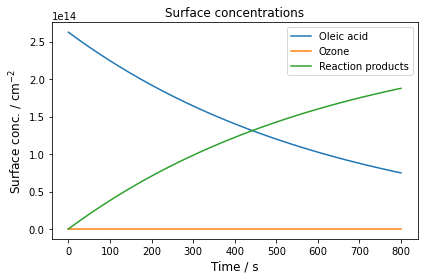

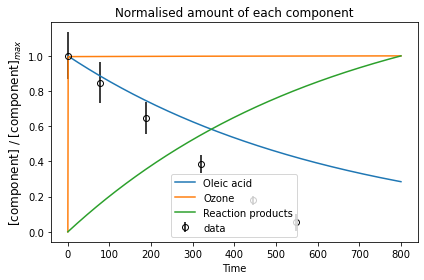

In [6]:
# import the Simulate class
from multilayerpy.simulate import Simulate

# import the Parameter class
from multilayerpy.build import Parameter

# make the parameter dictionary
# SETTING BULK DIFFUSION AND HENRY'S LAW PARAMETERS TO 0.0
param_dict = {'delta_3':Parameter(1e-7),
              'alpha_s_0_2':Parameter(1e-3,vary=True,bounds=(1e-4,1e-2)),
              'delta_2':Parameter(0.4e-7),
              'Db_2':Parameter(0.0),
              'delta_1':Parameter(0.8e-7),
              'Db_1':Parameter(0.0),
              'Db_3':Parameter(0.0),
              'k_1_2':Parameter(0.0),
              'H_2':Parameter(0.0),
              'Xgs_2': Parameter(323.0 * 2.46e10),
              'Td_2': Parameter(1e-7,vary=True,bounds=(1e-8,1e-5)),
              'w_2':Parameter(3.6e4),
              'T':Parameter(294.0),
              'k_1_2_surf':Parameter(2.2e-10,vary=True,bounds=(1e-11,1e-9))}

# import the data
from multilayerpy.simulate import Data

raw_data = np.genfromtxt('woden_etal_acp_data_uncert.csv',delimiter=',')

data = Data(raw_data)

# make the simulate object with the model and parameter dictionary
sim = Simulate(model,param_dict,data=data)

# define required parameters
n_layers = 5 # nominal 5 bulk layers
rp = 2e-4 # nominal film thickness in cm
time_span = [0,800] # in s
n_time = 999 # number of timepoints to save to output

#spherical V and A
# use simulate.make_layers function
V, A, layer_thick = simulate.make_layers(mod_type,n_layers,rp)

# initial conc. of everything
bulk_conc_dict = {'1':0.0,'2':0.0,'3':0.0} # key=model component number, value=bulk conc

# initial surf conc of oleic acid calculated from neutron reflectometry model fit
surf_conc_dict = {'1':262571428571428.56,'2':0.0,'3':0.0} # key=model component number, value=surf conc

y0 = simulate.initial_concentrations(mod_type,bulk_conc_dict,surf_conc_dict,n_layers) 
    
# now run the model
output = sim.run(n_layers,rp,time_span,n_time,V,A,layer_thick,Y0=y0)

%matplotlib inline
# plot the model
sim.plot(norm=True)

# There may be some runtime warnings because we are forcing some divisions by 0


Optimising using least_squares Nelder-Mead algorithm...



C:\Conda5\lib\site-packages\scipy\optimize\_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
C:\Users\milsomay\OneDrive - University of Birmingham\Bham_postdoc\kinetic-multilayer-package\kinetic-multilayer-model-builder\km-sub_Oleic acid ozonolysis.py:84: RuntimeWarning: invalid value encountered in true_divide
  fb_1 = y[0*Lorg+1:1*Lorg+0+1] / (y[0*Lorg+1:1*Lorg+0+1] + y[1*Lorg+2:2*Lorg+1+1]+ y[2*Lorg+3:3*Lorg+2+1])
C:\Users\milsomay\OneDrive - University of Birmingham\Bham_postdoc\kinetic-multilayer-package\kinetic-multilayer-model-builder\km-sub_Oleic acid ozonolysis.py:85: RuntimeWarning: invalid value encountered in true_divide
  fb_2 = y[1*Lorg+2:2*Lorg+1+1] / (y[0*Lorg+1:1*Lorg+0+1] + y[1*Lorg+2:2*Lorg+1+1]+ y[2*Lorg+3:3*Lorg+2+1])
C:\Users\milsomay\OneDrive - University of Birmingham\Bham_postdoc\kinetic-multilayer-package\kinetic-multilayer-model-builder\km-sub_Oleic acid ozonolysis.py:86: RuntimeWarning: invalid value

Optimization terminated successfully.
         Current function value: 1.416742
         Iterations: 26
         Function evaluations: 49
optimised params:

{'alpha_s_0_2': 0.0015386324940801378, 'Td_2': 1.2635536374921604e-07, 'k_1_2_surf': 2.6525124431997394e-10}

Success=: True ,termination message: Optimization terminated successfully.
number of iters: 26
final cost function value = 
1.4167421269595994


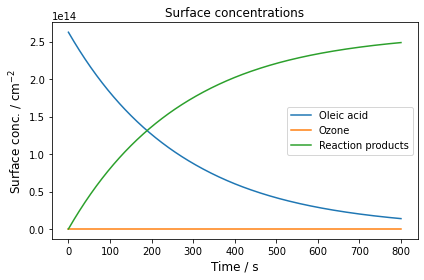

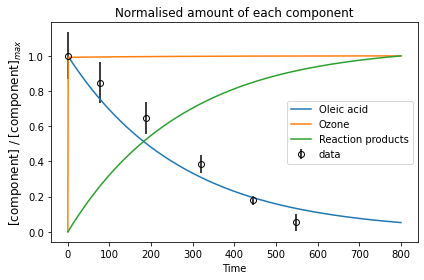

In [7]:
# now optimise the model

# import the optimize module and Optimizer object
import multilayerpy.optimize
from multilayerpy.optimize import Optimizer

fitter = Optimizer(sim)

res = fitter.fit(method='least_squares');


sim.plot(norm=True)